<a href="https://colab.research.google.com/github/faranak-jahedi/CryptoDataset/blob/main/ML_Lab_Excercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gradient Descent Lab

*  We implement our very own gradient descent algorithm to solve the task of predict median house values in Californian districts, given a number of features from these districts.
* In this notebook, we strip out a lot of the data investigation work. In addition, we only consider a small subset of the columns
* Read/run through the notebook and fund the exercises at the end


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np

import os
import tarfile
import urllib.request

import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


# Get the Data
   
   But first, few constant and f()s

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the Data

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create a Test Set

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [ ]:
len(test_set)

4128

# Discover and Visualize the Data to Gain Insights

## Lot's of graphs and geographical displays ... will skip for this lab

## Looking for Correlations ... will skip for this lab

## Experimenting with Attribute Combinations ... will skip for this lab

# Prepare the Data for Machine Learning Algorithms

## Data Cleaning ... minimal

In [ ]:
housing_cols = ['housing_median_age', 'total_rooms', 'population', 'median_income']
housing_num = housing[housing_cols].fillna(housing[housing_cols].median())
housing_labels = housing['median_house_value']

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

array([[ 0.98214266, -0.8048191 , -0.9744286 ,  2.34476576],
       [-0.60701891,  2.0458901 ,  0.86143887,  2.33223796],
       [ 1.85618152, -0.53574589, -0.82077735,  1.7826994 ],
       ...,
       [-0.92485123, -0.17499526, -0.3695372 , -1.14259331],
       [-0.84539315, -0.35559977, -0.60442933, -1.05458292],
       [-1.00430931,  0.06840827, -0.03397701, -0.78012947]])

# Select and Train a Model

## Easy way : Training and Evaluating on the Training Set

In [ ]:
sgd_reg = SGDRegressor(max_iter=10000, eta0=1e-3, tol=1e-3, random_state=42)
sgd_reg.fit(housing_num_tr, housing_labels)

SGDRegressor(eta0=0.001, max_iter=10000, random_state=42)

In [ ]:
housing_predictions = sgd_reg.predict(housing_num_tr)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse


80211.74173521325

In [ ]:
print(" theta values from SGD",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)

 theta values from SGD [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]


In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_num_tr, housing_labels)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_num_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

80211.61384149214

In [ ]:
print(" theta values from Linear regression",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)

 theta values from Linear regression [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]


## Manual SGD : Training and Evaluating on the Training Set

Sci-kit learn SGD and linear regression add a term for the y-intercept automatically, but we have to do it ourselves for the manual solution

In [ ]:
housing_num_tr_b = np.c_[np.ones((housing_num_tr.shape[0], 1)), housing_num_tr] # add x0 = 1 to each instance

### Exercise : Cost Function

Implement the Mean squared error cost function for a linear regression (Pg 114 of the book).
As a challenge, I encourage you to form the matrix/vector form of the equation. For loop is okay though

In [ ]:
# Define computeCost function
def computeCost(X, y, theta):
  m= len(y)
  # linear regression model prediction
  predictions= np.dot(X, theta)
  J= 1/(m) * np.sum((predictions -y)**2)
  return J

In [ ]:
print(housing_num_tr_b.shape)

(20640, 5)


We test out our cost function for specific theta values

In [ ]:
# Calculate computeCost with theta equal to zeros
theta = np.zeros(housing_num_tr_b.shape[1])

J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("With theta = %s, \nCost computed = %.2f " % (theta, J1))

#Answer Should be :
#    With theta = [0. 0. 0. 0. 0.],
#    Cost computed = 56104831989



With theta = [0. 0. 0. 0. 0.], 
Cost computed = 56104831989.87 


### Exercise : Batch Gradient Descent

Implement the batch gradient descent algorithm, save the cost at every iteration and return it along with
the improved theta value

In [ ]:
#  Define the gradient descent algorithm and return cost history and theta

def gradientDescent(X, y, theta, iterations, eta):
    J_hist = np.zeros([iterations])
    m=len(y)
    for iteration in range(iterations):
        gradients = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - eta * gradients
        cost =computeCost(X, y, theta)
        #Saving cost at every iteration
        J_hist[iteration]= cost
    return theta, J_hist

In [ ]:
print(housing_num_tr_b.shape)
print(len(housing_labels))
print(len(housing_cols))
print(len(housing_num))

(20640, 5)
20640
4
20640


Now run the batch gradient descent algorithm and check against my results

In [ ]:
theta, J_hist = gradientDescent(housing_num_tr_b, housing_labels, theta, iterations=5000,eta=1e-3)
J1 = computeCost(housing_num_tr_b, housing_labels, theta)
J1

# With theta initialized to zero, I get 3221295137.061254 for the cost

6435686288.119317

In [ ]:
print(" theta values from Manual BGD",theta[1:4])
print(" y intercept ", theta[0])

 theta values from Manual BGD [ 24751.15638111  17557.15835239 -10630.36667451]
 y intercept  206846.519237907


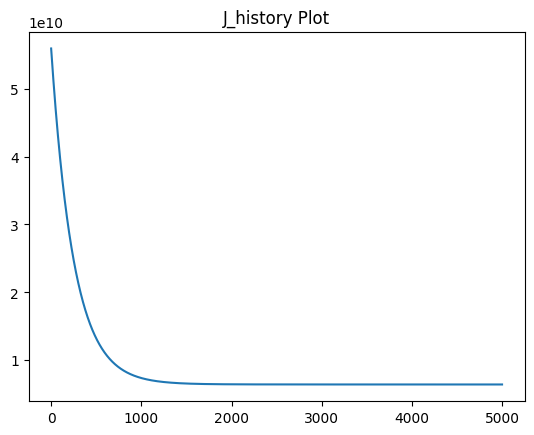

In [ ]:
# Lets look at how the cost changes through iterations
plt.title("J_history Plot")
plt.plot(J_hist)

### Exercise : Compute the root mean squared error

Compare results to linear regression and Stochastic gradient descent. Why do you think the results are not quite as good as the scikit learn results ? (May want to look

I get 80265.74782634563 with theta initialized to zero, iterations=5000,eta=1e-3

The RMSE are close but still different.The lower RMSE refers to better performance.So the one I compute seems to be a little more better.So my prediction is more close to actual values.I reckon that scikit learn use some hyperparameters by using its library to make the prrediction of a model better.

In [ ]:
X = housing_num_tr_b
y = housing_labels

m = len(y)
predictions = np.dot(X, theta)
gd_rmse = np.sqrt((1/m) * np.sum((predictions - y) ** 2))
gd_rmse

80222.72924875666

### Exercise : Hyperparameters

Change some of the hyperparameters (iterations or eta) to get an improved root mean squared (I was able to match scki-kit learn results of 80211)

In [ ]:
theta = np.zeros(housing_num_tr_b.shape[1])

theta, J_hist = gradientDescent(housing_num_tr_b, housing_labels, theta, iterations=10000,eta=1e-3)

X = housing_num_tr_b
y = housing_labels

m = len(y)
predictions = np.dot(X, theta)
gd_rmse_tweaked = np.sqrt((1/m) * np.sum((predictions - y) ** 2))
gd_rmse_tweaked

80212.6239099681

### Graduate students, Extra credit

Implement Stochastic gradient descent and compare the performance to batch gradient descent. Explain the results

In [ ]:
X = housing_num_tr_b
y = housing_labels

m = len(y)
def learning_schedule(t):
  return t0 / (t + t1)

def stochasticGradientDescent(n_epochs, t0, t1, theta):
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
            eta = learning_schedule(epoch * m + i)
            theta = theta - eta * gradients
    return theta

In [ ]:
n_ephocs=50
t0 , t1= 5, 50
theta= np.zeros(housing_num_tr_b.shape[1])
theta= stochasticGradientDescent(n_ephocs, t0, t1, theta)
theta

array([205911.58329277,  23078.22125784,  23980.5002188 , -13895.32700839,
        76516.28295119])

In [ ]:
predictions = np.dot(X, theta)
np.sqrt((1/m)* np.sum((predictions -y)**2))

80325.85973387596

When I ran the SGD, it comes to me that it was faster compare to Batch gradient descent and I get that the parameters t0 and t1 are one of the reasons.